In [5]:
%pip install numpy opencv-python


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\VscodeFiles\PYTHON\QUIZ\env\Scripts\python.exe -m pip install --upgrade pip' command.


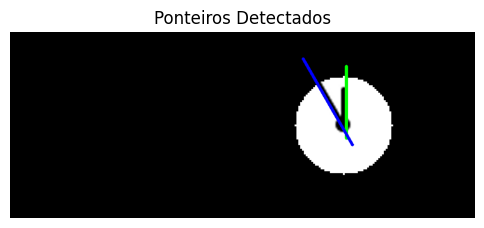

Horário detectado: 09:44


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_angle(x1, y1, x2, y2, cx, cy):
    angle_rad = np.arctan2(y2 - cy, x2 - cx) - np.arctan2(y1 - cy, x1 - cx)
    angle_deg = np.degrees(angle_rad)
    angle_deg = (angle_deg + 360) % 360
    return angle_deg

image_path = "clock_1.png"

imagem = cv2.imread(image_path, cv2.IMREAD_COLOR)

cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

suave = cv2.medianBlur(cinza, 5)

circulos = cv2.HoughCircles(
    suave,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=40,
    param1=50,
    param2=30,
    minRadius=15,
    maxRadius=60,
)

vertices = []

if circulos is not None:
    circulos = np.round(circulos[0, :]).astype("int")

    x, y, raio = circulos[0]

    mask = np.zeros_like(cinza)
    cv2.circle(mask, (x, y), int(raio * 0.70), 255, -1)

    masked_image = cv2.bitwise_and(imagem, imagem, mask=mask)

    x1, y1 = x - int(raio * 0.80), y - int(raio * 0.80)
    x2, y2 = x + int(raio * 0.80), y + int(raio * 0.80)
    cropped_image = masked_image[y1:y2, x1:x2]

    scale_factor = 4
    width = int(imagem.shape[1] * scale_factor)
    height = int(imagem.shape[0] * scale_factor)
    high_quality_image = cv2.resize(imagem, (width, height), interpolation=cv2.INTER_CUBIC)
    high_quality_gray = cv2.cvtColor(high_quality_image, cv2.COLOR_BGR2GRAY)
    high_quality_mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    high_quality_masked_image = cv2.bitwise_and(high_quality_image, high_quality_image, mask=high_quality_mask)

    gray = cv2.cvtColor(high_quality_masked_image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)  # Ajustado para melhor detecção

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10  # Ajustado threshold
    )

    line_image = np.copy(high_quality_masked_image)

    longest_line_minute = None
    max_length_minute = 0
    longest_line_hour = None
    max_length_hour = 0

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = line_length(x1, y1, x2, y2)
            thickness = cv2.norm(gray[y1:y2, x1:x2], cv2.NORM_L2) / length

            if thickness > 5:  # Ajustado limite de espessura
                if length > max_length_hour:
                    max_length_hour = length
                    longest_line_hour = (x1, y1, x2, y2)
            else:
                if length > max_length_minute:
                    max_length_minute = length
                    longest_line_minute = (x1, y1, x2, y2)

        if longest_line_minute is not None:
            x1, y1, x2, y2 = longest_line_minute
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
            new_length = length * 1.8
            x1_new = int(x1 - direction_vector[0] * (new_length - length))
            y1_new = int(y1 - direction_vector[1] * (new_length - length))
            x2_new = int(x2 + direction_vector[0] * (new_length - length))
            y2_new = int(y2 + direction_vector[1] * (new_length - length))
            cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 5)
            vertices.append((x1, y1))
            vertices.append((x2, y2))

        if longest_line_hour is not None:
            x1, y1, x2, y2 = longest_line_hour
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            direction_vector = ((x2 - x1) / length, (y2 - y1) / length)
            new_length = length * 1.8
            x1_new = int(x1 - direction_vector[0] * (new_length - length))
            y1_new = int(y1 - direction_vector[1] * (new_length - length))
            x2_new = int(x2 + direction_vector[0] * (new_length - length))
            y2_new = int(y2 + direction_vector[1] * (new_length - length))
            cv2.line(line_image, (x1_new, y1_new), (x2_new, y2_new), (255, 0, 0), 5)
            vertices.append((x1, y1))
            vertices.append((x2, y2))

        def adjust_angle(angle):
            adjusted_angle = (angle - 90) % 360
            return adjusted_angle if adjusted_angle >= 0 else adjusted_angle + 360

        hour_angle = calculate_angle(*longest_line_hour, x, y) if longest_line_hour else 0
        minute_angle = calculate_angle(*longest_line_minute, x, y) if longest_line_minute else 0

        adjusted_hour_angle = adjust_angle(hour_angle)
        adjusted_minute_angle = adjust_angle(minute_angle)

        hour = int(adjusted_hour_angle / 30)
        minute = int(adjusted_minute_angle / 6)

        # print(f"Ângulo da haste verde (hora): {adjusted_hour_angle:.4f} graus")
        # print(f"Ângulo da haste azul (minuto): {adjusted_minute_angle:.4f} graus")

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.title("Ponteiros Detectados")
    plt.axis('off')
    plt.show()
    print(f"Horário detectado: {hour:02d}:{minute:02d}")

else:
    print("Nenhum círculo detectado")
